# ДЗ_5. "Разложение данных временных рядов с помощью анализа сингулярного спектра"

## Задание

- Проведите анализ с помощью SSA в любом из временных рядов с первого занятия.
- При желании можете воспользоваться своим временным рядом — работа, Kaggle и т. д.
- Посмотрите на результаты с разными длинами окон.
- Обязательно визуализируйте результаты аналогично материалу с занятия.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Fiddle with figure settings here:
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 14
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2
# Set the default colour cycle (in case someone changes it...)
from cycler import cycler
cols = plt.get_cmap('tab10').colors
plt.rcParams['axes.prop_cycle'] = cycler(color=cols)

## Решение 
(большая часть функций и кода из лекции!)

In [4]:
# Временной ряд, как я брал в предыдущих заданиях

airlines_passengers = pd.read_csv("../Series/international-airline-passengers.csv")

In [5]:
series = {"International airline passengers: monthly totals in thousands": airlines_passengers["Count"]}

In [6]:
# A simple little 2D matrix plotter, excluding x and y labels.
def plot_2d(m, title=""):
    plt.imshow(m)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

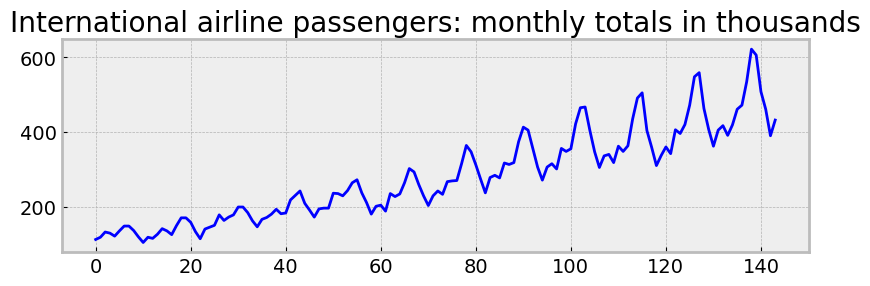

In [7]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(series.keys()):
        x = i % 2
        y = int((i - x) / 2)

        ts_ax = plt.subplot2grid(layout, (y, x))
        series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)

    plt.tight_layout()

#### Далее строим матрицу траекторий

> Так как нам нужно получить результаты с разными длинами окон, то напишем цикл, где переберем разные длины окон

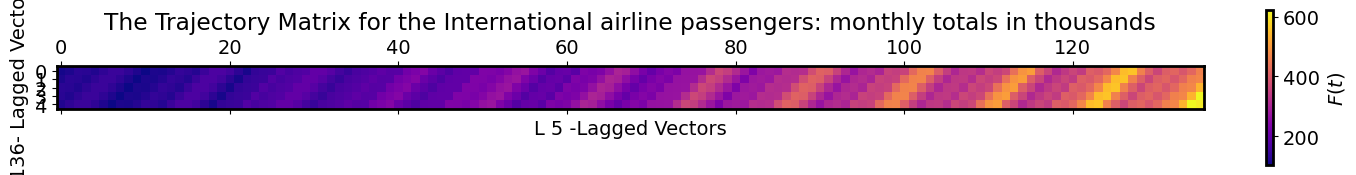

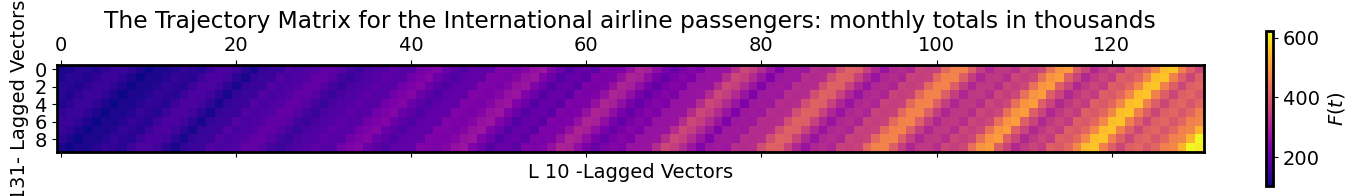

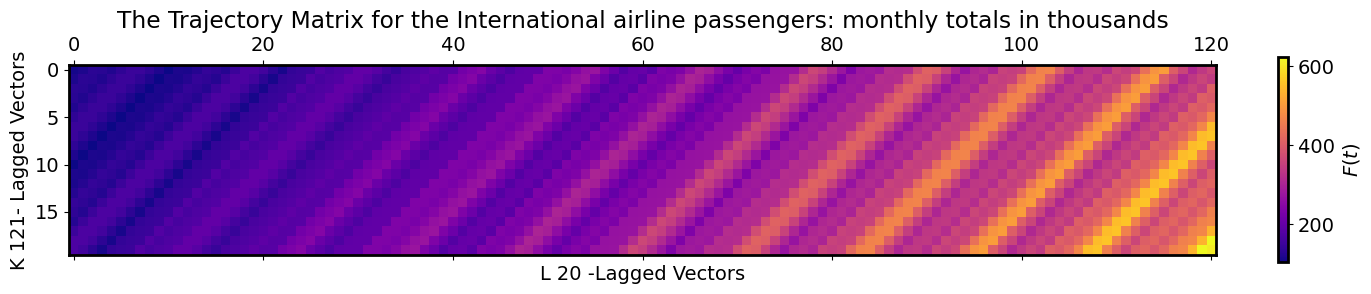

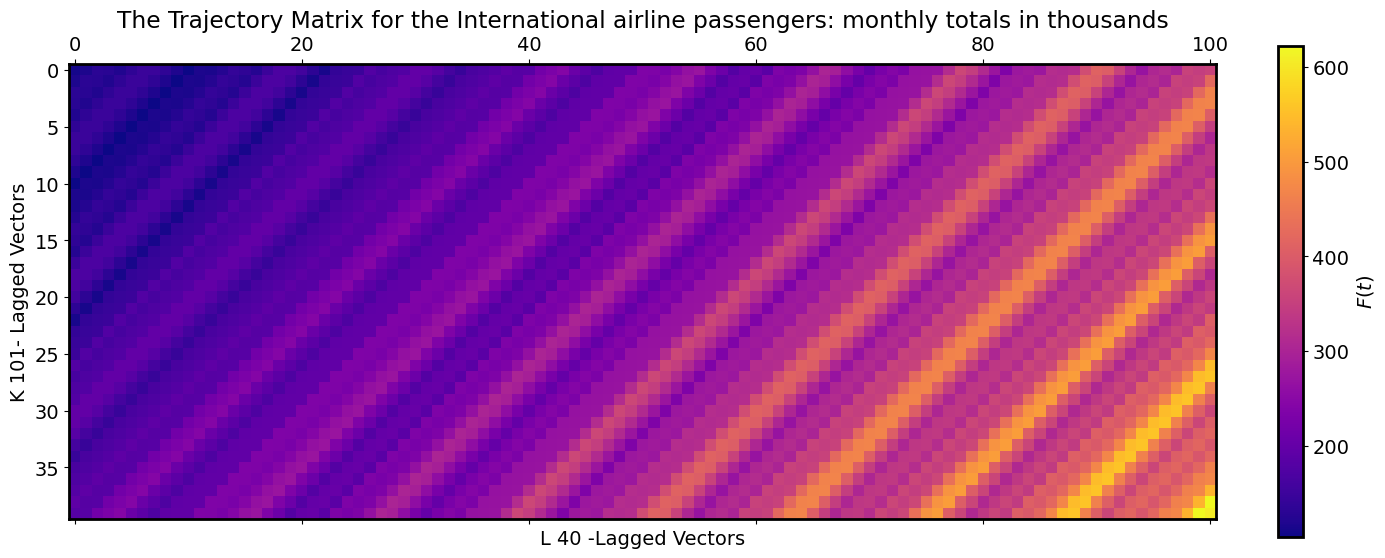

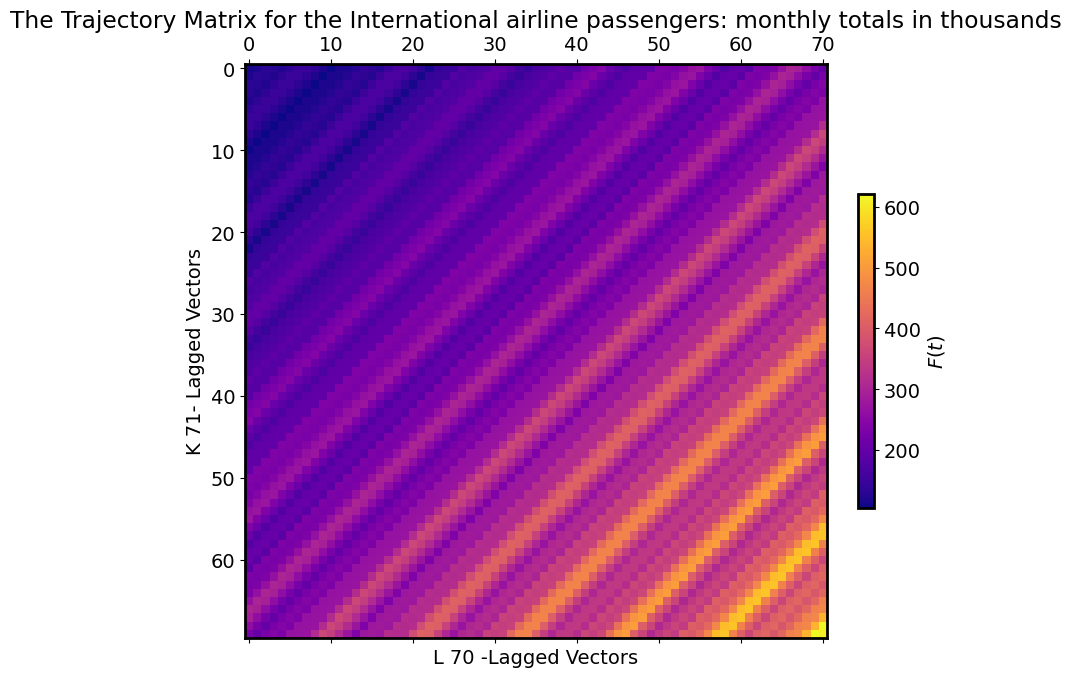

In [8]:
N = 140 # длина ряда
win = [5, 10, 20, 40, 70]
F = airlines_passengers["Count"]
for L in win:
    K = N - L + 1 # The number of columns in the trajectory matrix.

    # Create the trajectory matrix by pulling the relevant subseries of F, and stacking them as columns.
    X = np.column_stack([F[i:i+L] for i in range(0,K)])
    # Note: the i+L above gives us up to i+L-1, as numpy array upper bounds are exclusive. 
    ax = plt.matshow(X)
    # plt.xlabel("$L$-Lagged Vectors")
    plt.xlabel(f'L {L} -Lagged Vectors')
    plt.ylabel(f'K {K}- Lagged Vectors')
    plt.colorbar(ax.colorbar, fraction=0.025)
    ax.colorbar.set_label("$F(t)$")
    plt.title("The Trajectory Matrix for the International airline passengers: monthly totals in thousands");

#### Разложим матрицу траекторий и сформируем ее элементарные матрицы

In [9]:
def elematrix_decomposition(X,m):
    """
    Функция разложение матрицы траекторий и вывод n - элементарных матриц 
    (формулы из лекций, оформленные функцией)
    """
    d = np.linalg.matrix_rank(X) # The intrinsic dimensionality of the trajectory space.
    U, Sigma, V = np.linalg.svd(X)
    V = V.T
    
    # Calculate the elementary matrices of X, storing them in a multidimensional NumPy array.
    # This requires calculating sigma_i * U_i * (V_i)^T for each i, or sigma_i * outer_product(U_i, V_i). 
    # Note that Sigma is a 1D array of singular values, instead of the full L x K diagonal matrix.
    X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )
    
    # Quick sanity check: the sum of all elementary matrices in X_elm should be equal to X, to within a 
    # *very small* tolerance:
    if not np.allclose(X, X_elem.sum(axis=0), atol=1e-10):
        print("WARNING: The sum of X's elementary matrices is not equal to X!")
        return;
    n = min(m, d) # In case d is less than 12 for the series. Say, if we were to exclude the noise component...
    for i in range(n):
        plt.subplot(4,4,i+1)
        title = "$\mathbf{X}_{" + str(i) + "}$"
        plot_2d(X_elem[i], title)
    plt.tight_layout()

> Для того, что бы передать в фукцию матрицы траекторий нужно написать еще одну функцию для матриц траекторий

In [10]:
def trajectory_matrix(F,N,L):
    K = N - L + 1 # The number of columns in the trajectory matrix.
    # Create the trajectory matrix by pulling the relevant subseries of F, and stacking them as columns.
    X = np.column_stack([F[i:i+L] for i in range(0,K)])
    return X

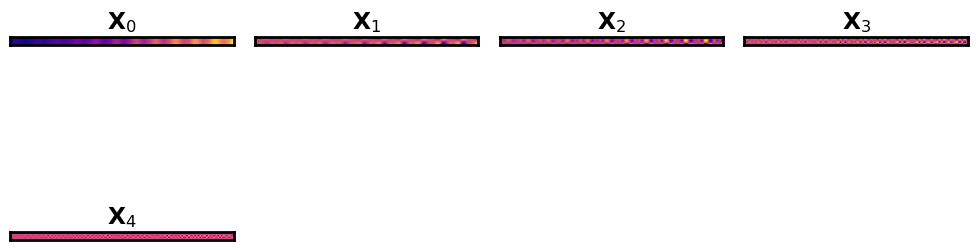

In [11]:
elematrix_decomposition(trajectory_matrix(F,N,5),12)

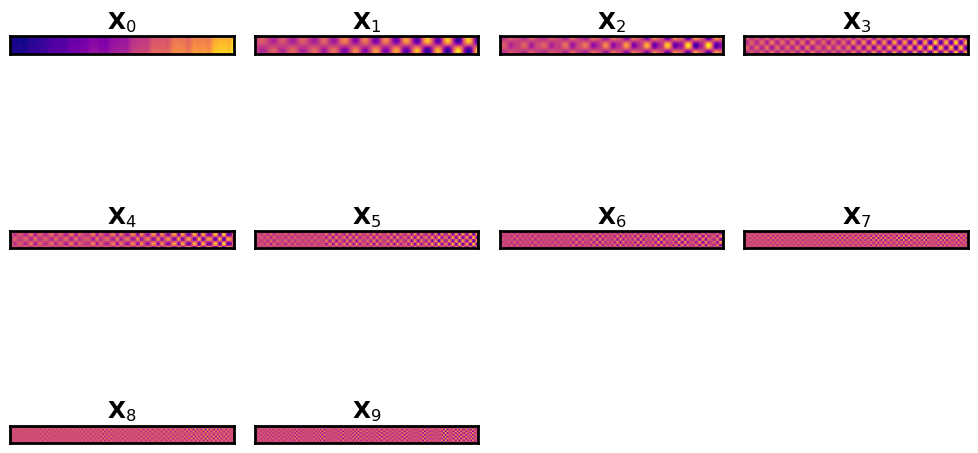

In [12]:
elematrix_decomposition(trajectory_matrix(F,N,10),12)

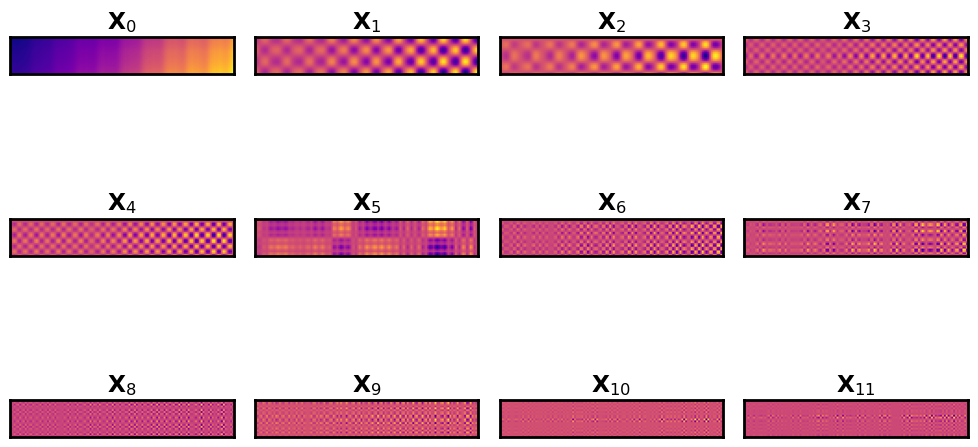

In [13]:
elematrix_decomposition(trajectory_matrix(F,N,20),12)

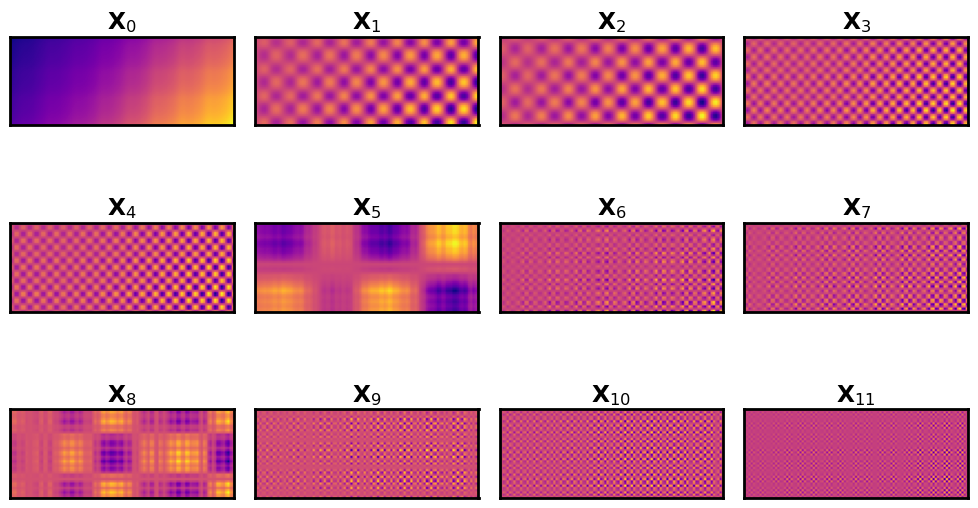

In [14]:
elematrix_decomposition(trajectory_matrix(F,N,40),12)

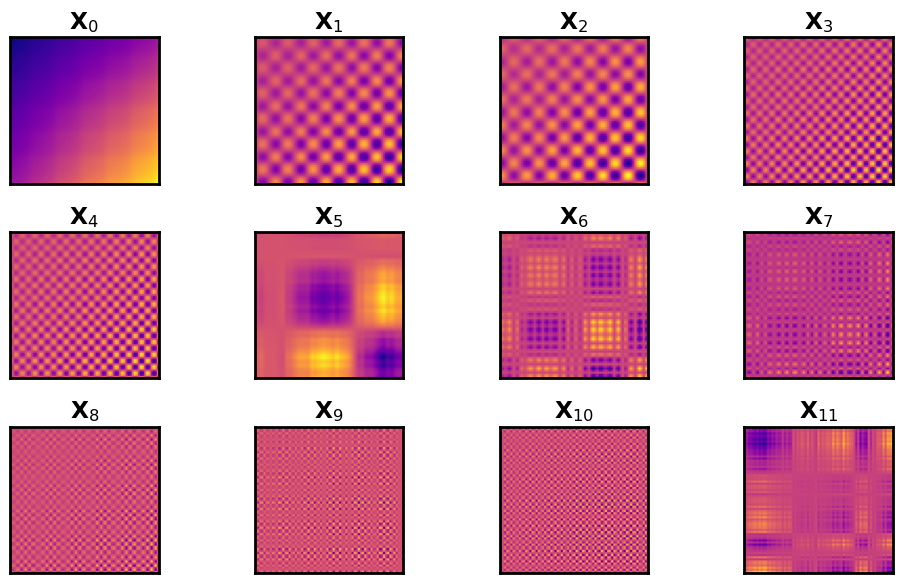

In [15]:
elematrix_decomposition(trajectory_matrix(F,N,70),12)

Из Лекции, реализуем процедуру Ханкелизации. Однако, согласно лектору, мы не должны слишком привязывайтесь к этому

Поскольку временной ряд однозначно определяется из матрицы Ханкеля.
Мы должны сгруппировать эти компоненты вместе и классифицировать их как тренд, периодичность или шум, а затем мы вольны решать, как мы их используем.

In [16]:
def Hankelise(X):
    """
    Hankelises the matrix X, returning H(X).
    """
    L, K = X.shape
    transpose = False
    if L > K:
        # The Hankelisation below only works for matrices where L < K.
        # To Hankelise a L > K matrix, first swap L and K and tranpose X.
        # Set flag for HX to be transposed before returning. 
        X = X.T
        L, K = K, L
        transpose = True

    HX = np.zeros((L,K))
    
    # I know this isn't very efficient...
    for m in range(L):
        for n in range(K):
            s = m+n
            if 0 <= s <= L-1:
                for l in range(0,s+1):
                    HX[m,n] += 1/(s+1)*X[l, s-l]    
            elif L <= s <= K-1:
                for l in range(0,L-1):
                    HX[m,n] += 1/(L-1)*X[l, s-l]
            elif K <= s <= K+L-2:
                for l in range(s-K+1,L):
                    HX[m,n] += 1/(K+L-s-1)*X[l, s-l]
    if transpose:
        return HX.T
    else:
        return HX

Повторим частично предыдущую функция, для вывода нескольких окон 
(убрал комментарии что бы уменьшить код и была лучше читаемость.

In [17]:
def elematrix_hankelisse(X,m):
    d = np.linalg.matrix_rank(X)
    U, Sigma, V = np.linalg.svd(X)
    V = V.T
    X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )
    n = min(d, m)
    for j in range(0,n):
        plt.subplot(4,4,j+1)
        title = r"$\tilde{\mathbf{X}}_{" + str(j) + "}$"
        plot_2d(Hankelise(X_elem[j]), title)
    plt.tight_layout()

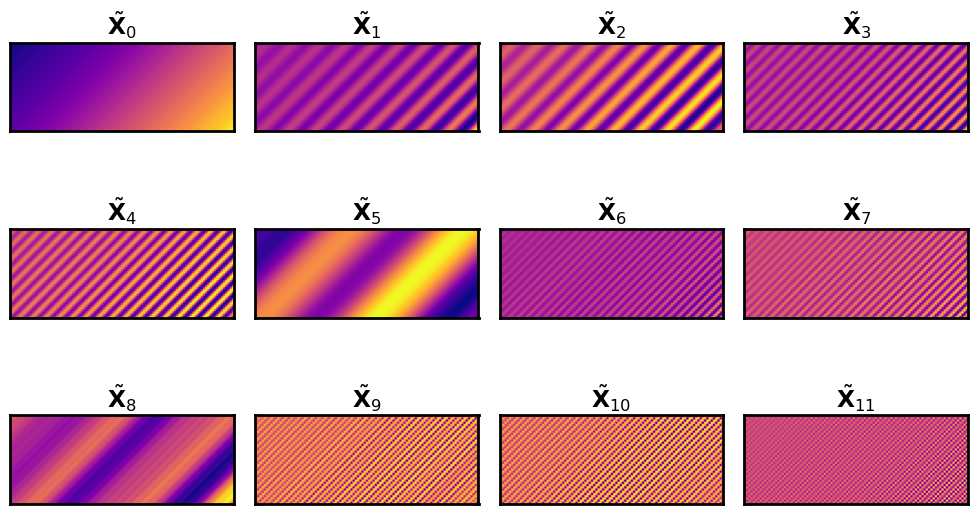

In [18]:
# так как это упражнение, согласно лекции, не является основым, то не буду выводить все окна, а приведу примеры 2-х окон
elematrix_hankelisse(trajectory_matrix(F,N,40),12)

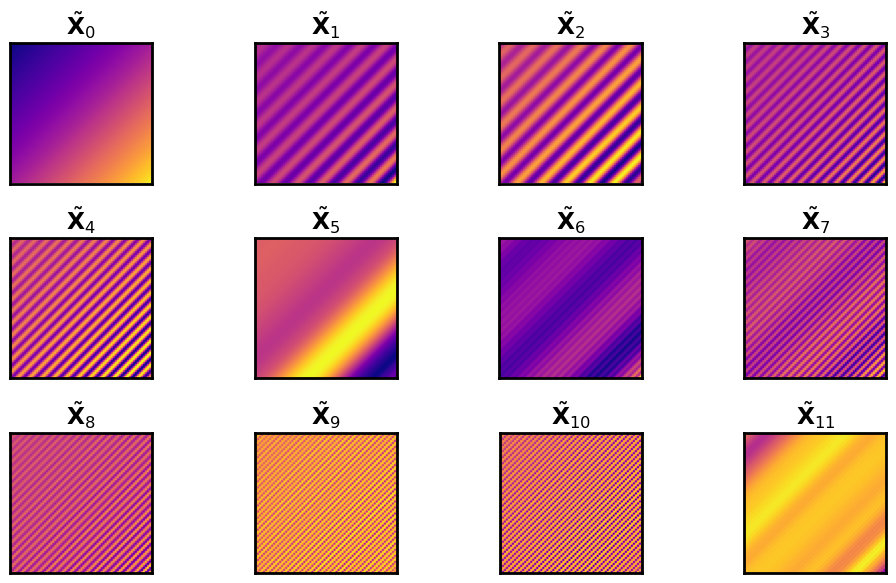

In [19]:
elematrix_hankelisse(trajectory_matrix(F,N,70),12)

> Вывод:
> 1. Рассмотрим полученные графики
> 2. С большой долей веротяности лучше использовать окно размером 70, так как от туда можно вытащить больше информации
> 3. Проверка элементарных матриц Ханкеля нашего временного ряда подтверждает наши подозрения относительно элементарных матриц:\
> a. 𝐗̃ 1 и 𝐗̃ 2 являются периодическими с одинаковой частотой и могут быть сгруппированы как первый периодический компонент. \
> b. 𝐗̃ 3 и 𝐗̃ 4 также являются периодическими, с другой частотой, чем  𝐗̃ 1 и  𝐗̃ 2,  и будут сгруппированы как второй периодический компонент.\
> c. 𝐗̃ 0, 𝐗̃ 5, 𝐗̃ 6 объеденим как компонент тренда.\
> d. Остальные компоненты больше похожи на шум. 


Хотя мы определили группировку компонентов временного ряда в терминах элементарных матриц Ханкеля, \
мы больше не будем вычислять полную матрицу Ханкеля  𝐗̃ 𝑖, а вместо этого вычисляем  𝐹̃ 𝑖 непосредственно из  𝐗𝑖.\
Далее мы сделаем это с помощью двух строк Python!

In [20]:
def X_to_TS(X_i):
    """Averages the anti-diagonals of the given elementary matrix, X_i, and returns a time series."""
    # Reverse the column ordering of X_i
    X_rev = X_i[::-1]
    # Full credit to Mark Tolonen at https://stackoverflow.com/a/6313414 for this one:
    return np.array([X_rev.diagonal(i).mean() for i in range(-X_i.shape[0]+1, X_i.shape[1])])

Давайте продолжим и построим первые 12 элементарных компонентов, $\tilde{F}_i$, для нашего временного ряда.

In [21]:
def plot_h(X, N, m):
    t = np.arange(0, N)
    d = np.linalg.matrix_rank(X) # The intrinsic dimensionality of the trajectory space.
    U, Sigma, V = np.linalg.svd(X)
    V = V.T
    X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )
    n = min(m, d) # In case of noiseless time series with d < 12.

    # Fiddle with colour cycle - need more colours!
    fig = plt.subplot()
    color_cycle = cycler(color=plt.get_cmap('tab20').colors)
    fig.axes.set_prop_cycle(color_cycle)

    # Convert elementary matrices straight to a time series - no need to construct any Hankel matrices.
    for i in range(n):
        F_i = X_to_TS(X_elem[i])
        fig.axes.plot(t, F_i, lw=2)

    fig.axes.plot(t, F[:N], alpha=1, lw=1)
    fig.set_xlabel("$t$")
    fig.set_ylabel(r"$\tilde{F}_i(t)$")
    legend = [r"$\tilde{F}_{%s}$" %i for i in range(n)] + ["$F$"]

    fig.legend(legend, loc=(1.05,0.1));



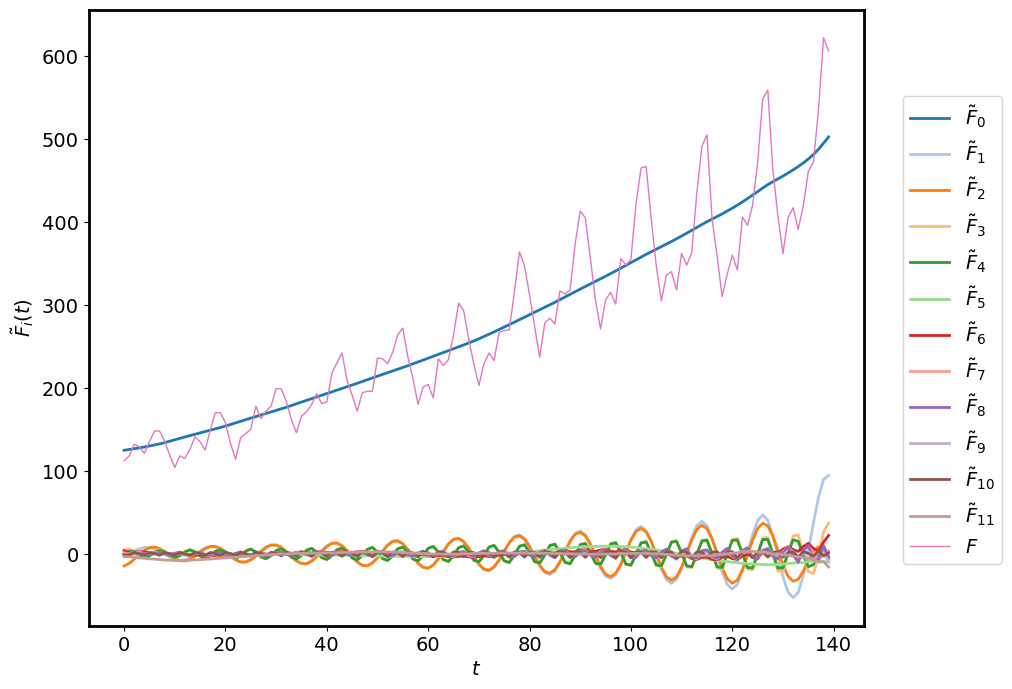

In [22]:
plot_h(X, 140, 12)

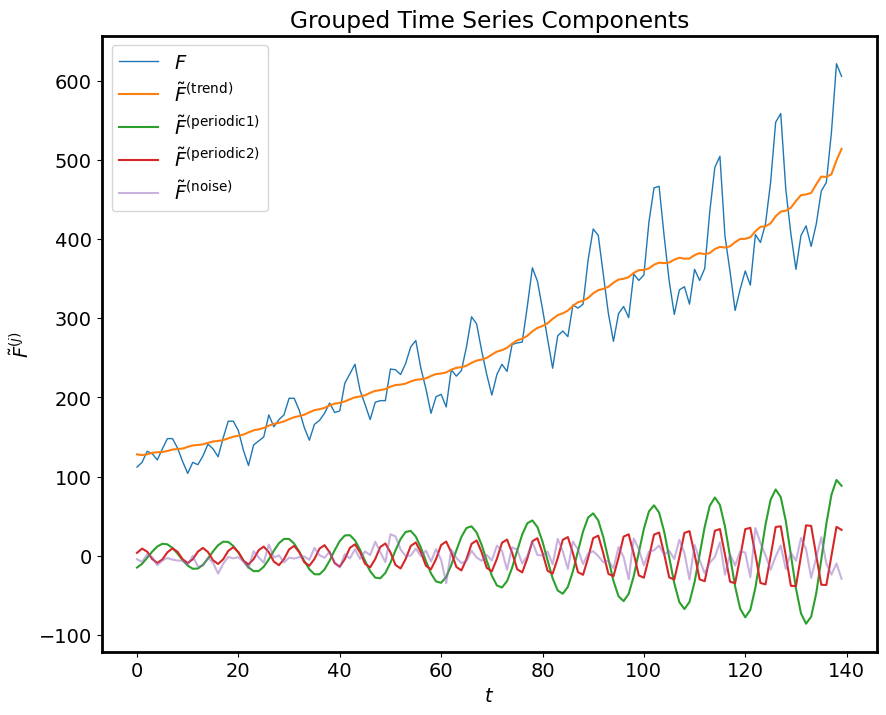

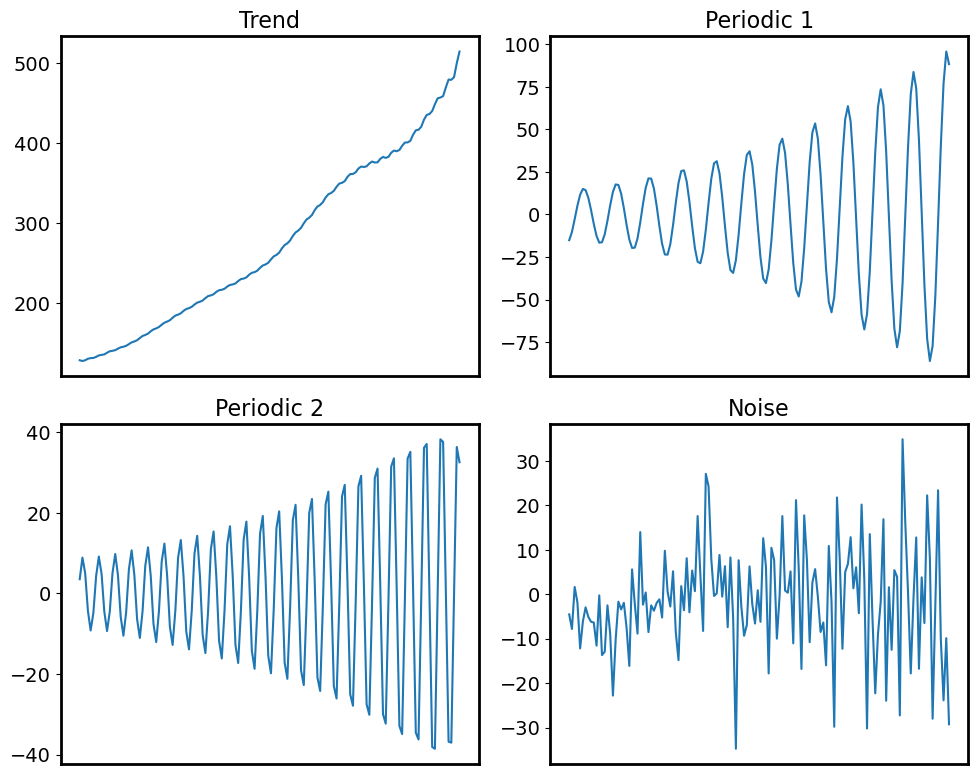

In [23]:
# Assemble the grouped components of the time series.

t = np.arange(0,140) 
d = np.linalg.matrix_rank(X) # The intrinsic dimensionality of the trajectory space.
U, Sigma, V = np.linalg.svd(X)
V = V.T
X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )

# Trim the longer array
if len(t) > len(F):
    t = t[:len(F)]
elif len(F) > len(t):
    F = F[:len(t)]


# Assemble the grouped components of the time series.
F_trend = X_to_TS(X_elem[[0,5,6]].sum(axis=0))
F_periodic1 = X_to_TS(X_elem[[1,2]].sum(axis=0))
F_periodic2 = X_to_TS(X_elem[[3,4]].sum(axis=0))
F_noise = X_to_TS(X_elem[7:].sum(axis=0))

# Plot the toy time series and its separated components on a single plot.
plt.plot(t,F, lw=1)
plt.plot(t, F_trend)
plt.plot(t, F_periodic1)
plt.plot(t, F_periodic2)
plt.plot(t, F_noise, alpha=0.5)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}^{(j)}$")
groups = ["trend", "periodic 1", "periodic 2", "noise"]
legend = ["$F$"] + [r"$\tilde{F}^{(\mathrm{%s})}$"%group for group in groups]
plt.legend(legend)
plt.title("Grouped Time Series Components")
plt.show()

# A list of tuples so we can create the next plot with a loop.
components = [("Trend", F_trend), 
              ("Periodic 1", F_periodic1),
              ("Periodic 2", F_periodic2),
              ("Noise", F_noise)]

# Plot the separated components and original components together.
fig = plt.figure()
n=1
for name, ssa_comp in components:
    ax = fig.add_subplot(2,2,n)

    ax.plot(t, ssa_comp)
    ax.set_title(name, fontsize=16)
    ax.set_xticks([])
    n += 1

fig.tight_layout()

#### Построим w-корреляционную матрицу для временного ряда

In [24]:
def corr_matrix(X,L,N):

    t = np.arange(0, N) 
    d = np.linalg.matrix_rank(X) # The intrinsic dimensionality of the trajectory space.
    U, Sigma, V = np.linalg.svd(X)
    V = V.T
    X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )
    # Get the weights w first, as they'll be reused a lot.
    # Note: list(np.arange(L)+1) returns the sequence 1 to L (first line in definition of w),
    # [L]*(K-L-1) repeats L K-L-1 times (second line in w definition)
    # list(np.arange(L)+1)[::-1] reverses the first list (equivalent to the third line)
    # Add all the lists together and we have our array of weights.
    w = np.array(list(np.arange(L)+1) + [L]*(K-L-1) + list(np.arange(L)+1)[::-1])

    # Get all the components of the toy series, store them as columns in F_elem array.
    F_elem = np.array([X_to_TS(X_elem[i]) for i in range(d)])

    # Calculate the individual weighted norms, ||F_i||_w, first, then take inverse square-root so we don't have to later.
    F_wnorms = np.array([w.dot(F_elem[i]**2) for i in range(d)])
    F_wnorms = F_wnorms**-0.5

    # Calculate the w-corr matrix. The diagonal elements are equal to 1, so we can start with an identity matrix
    # and iterate over all pairs of i's and j's (i != j), noting that Wij = Wji.
    Wcorr = np.identity(d)
    for i in range(d):
        for j in range(i+1,d):
            Wcorr[i,j] = abs(w.dot(F_elem[i]*F_elem[j]) * F_wnorms[i] * F_wnorms[j])
            Wcorr[j,i] = Wcorr[i,j]
    return Wcorr

График w-корреляционной матрицы.

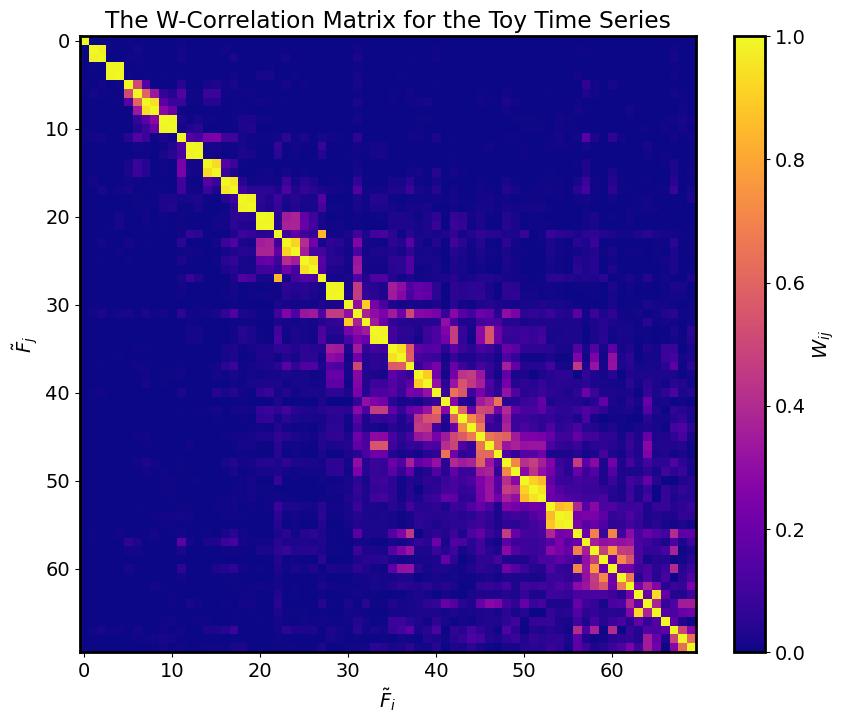

In [25]:
def corr_plot(Wcorr):
    ax = plt.imshow(Wcorr)
    plt.xlabel(r"$\tilde{F}_i$")
    plt.ylabel(r"$\tilde{F}_j$")
    plt.colorbar(ax.colorbar, fraction=0.045)
    ax.colorbar.set_label("$W_{ij}$")
    plt.clim(0,1)
    plt.title("The W-Correlation Matrix for the Toy Time Series");

corr_plot(corr_matrix(X,70,140))

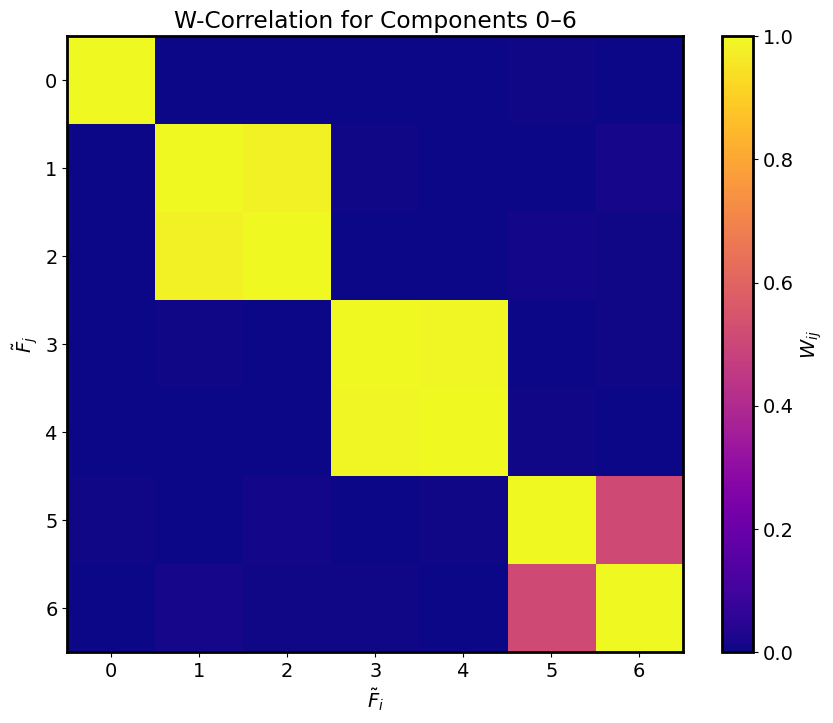

In [26]:
# Масштабирование первых семи компонентов в  𝐖corr

def corr_plot_first(Wcorr):
    ax = plt.imshow(Wcorr)
    plt.xlabel(r"$\tilde{F}_i$")
    plt.ylabel(r"$\tilde{F}_j$")
    plt.colorbar(ax.colorbar, fraction=0.045)
    ax.colorbar.set_label("$W_{ij}$")
    plt.xlim(-0.5,6.5)
    plt.ylim(6.5,-0.5)
    plt.clim(0,1)
    plt.title(r"W-Correlation for Components 0–6");

corr_plot_first(corr_matrix(X,70,140))

> Вывод: 
> На графике видно, что изначальная групировка, основанная на внешнем виде подтверждается.
> Мы провели анализ с помощью SSA.
> Посмотрели на результаты с разными длинами окон.
> Визуализировали результаты аналогично материалу с занятия.
